In [1]:
%matplotlib nbagg
from __future__ import division
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as data
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Dataset
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.io import loadmat
from itertools import chain
import os
from tqdm import tqdm
import sys
import pymatgen as mg
from pymatgen.io.vasp.inputs import Poscar

/Applications/anaconda2/lib/python2.7/site-packages/pymatgen/__init__.py:89: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")


In [2]:
# Input data dimension: dictionary of 4 elements: 'abc', 'H', 'Pd', and 'Ni' for e.g. (or more generally 'X' and 'Y' metals)
# 'abc': 3x3 matrix
# 'H': nHx3 matrix, with nH being the max number of H atoms among all POSCARs
# 'Pd' (or 'X'): nXx3 matrix, with nX being the max number of X atoms among all POSCARs
# 'Ni' (or 'Y'): nYx3 matrix, with nY being the max number of Y atoms among all POSCARs
#
# The overall input data dimension is hence (3 + nH + nX + nY) * 3

In [3]:
def get_dimension_input_data(d_array1, d_array2):
    """Given two arrays of "binary" POSCAR files (obtained after loading the corresponding .mat files),
    returns:
    - Maximum number, nH, of hydrogen atoms over all POSCARs (of both databases),
    - Maxim number, nX, of metal X atoms over all POSCARs,
    - Maxim number, nY, of metal Y atoms over all POSCARs.
    
    Input arrays are of shape (nb_poscars, 4).
    
    Remarks:
    - For a binary component that does not contain metal X (or Y),
    the position corresponding to the latter is represented by a (18, 3) array.
    Therefore, the input data is already preprocessed at the creation of the .mat files.
    - The order of the input arguments matter.
    """
    nH = nX = nY = 0
    # Compute max number of metal atoms
    # Metal atoms are situated either at position 2 or 3 in
    # the array corresponding to the loaded .mat file
    #
    # In Asma's implementation:
    # - position 2 corresponds to Pd (resp. Mg)
    # - position 3 corresponds to Ni (resp. Ti)
    for i in range(len(d_array1)):
        if len(d_array1[i][1]) > nH:
            nH = len(d_array1[i][1])
        if len(d_array1[i][2]) > nX:
            nX = len(d_array1[i][2])
            
    for i in range(len(d_array2)):
        if len(d_array2[i][1]) > nH:
            nH = len(d_array1[i][1])
        if len(d_array2[i][3]) > nY:
            nY = len(d_array2[i][3])
            
    return nH, nX, nY

In [7]:
# Load data from .mat files of interest (change path accordingly)
# The result is a dictionary of two lists of POSCAR files
data_directory = 'Crystallographic_databases/'
metals = ['Ti', 'Ni']
databases = ['Ti_POSCAR.mat', 'Ni_POSCAR_data.mat']
# Remark: The order of metallic atoms in 'metals' is important.
# The database corresponding to the first (resp. second) metal
# must be the one structured as follows:
#
# abc
# H atoms
# A atoms (resp. zeros)
# Zeros (resp. B atoms)

# Only load the dictionary element that contains the POSCARs
raw_data = {x: loadmat(data_directory + y)[y[:-4]] for x, y in zip(metals, databases)}
# Folder containing POSCARs generated by the GAN
generated_data = 'Generated_POSCAR_files/' + metals[0] + '-' + metals[1] + '/'
pseudobinary_X_data = 'Pseudobinary_data/' + metals[0] + '_poscars/'
pseudobinary_Y_data = 'Pseudobinary_data/' + metals[1] + '_poscars/'
ternary_X_data = 'Ternary_data/' + metals[0] + "-" + metals[1] + '_poscars/'
ternary_Y_data = 'Ternary_data/' + metals[1] + "-" + metals[0] + '_poscars/'
# npy_data = 'Ternary_data/npy_data/'

In [5]:
nH, nX, nY = get_dimension_input_data(raw_data[metals[0]], raw_data[metals[1]])

In [6]:
# Data manipulation functions

In [7]:
def data_preprocessing(poscar):
    """
    Given a POSCAR in the form of a numpy array, transforms it into
    a (3 + nH + nX + nY, 3) array. The first 3 lines correspond to
    the abc coordinates (lattice parameters) in the POSCAR
    """
    result = np.zeros((3 + nH + nX + nY, 3), dtype=np.float32)
    result[0:poscar[0].shape[0], 0:poscar[0].shape[1]] = poscar[0]
    result[3:3 + poscar[1].shape[0], 0:poscar[1].shape[1]] = poscar[1]
    # This test is done to save space. Due to preprocessing while creating
    # .mat files, inexisting metal positions are filled with a (18, 3) array
    # although nX and nY are smaller than 18
    if poscar[2].shape[0] > nX:
        result[3 + nH:3 + nH + nX, 0:poscar[2].shape[1]] = poscar[2][0:nX, :]
    else:
        result[3 + nH:3 + nH + poscar[2].shape[0], 0:poscar[2].shape[1]] = poscar[2]
        
    if poscar[3].shape[0] > nY:
        result[3 + nH + nX:3 + nH + nX + nY, 0:poscar[3].shape[1]] = poscar[3][0:nY, :]
    else:
        result[3 + nH + nX:3 + nH + nX + poscar[3].shape[0], 0:poscar[3].shape[1]] = poscar[3]
        
    return result 

In [8]:
# Postprocessing results (pseudobinary and ternary components)
def data_postprocessing(data, metal=None):
    """
    This function takes a (3 + nH + nX + nY, 3) array corresponding to a binary
    or ternary component (metal X), removes the part corresponding to metal Y as well as
    potentially duplicated rows (if metal != None), and returns a string following a POSCAR format
    """
    res = ""
    tmp_data = data.detach().numpy()
    abc = tmp_data[:3, :] # lattice parameters
    # np.unique(...) is used to get rid of potentially redundant rows
    tmp_H, idx_H = np.unique(tmp_data[3:3 + nH, :], axis=0, return_index=True)
    if len(idx_H) > 1: #  and len(idx_H) < len(tmp_data[3:3 + nH, :])?
        H = tmp_data[3:3 + nH, :][sorted(idx_H)[:-1]] # H atoms
    else:
        H = tmp_data[3:3 + nH, :][sorted(idx_H)]
    tmp_X, idx_X = np.unique(tmp_data[3 + nH:3 + nH + nX, :], axis=0, return_index=True)
    if len(idx_X) > 1:
        X = tmp_data[3 + nH:3 + nH + nX, :][sorted(idx_X)[:-1]] # X (Pd here) atoms
    else:
        X = tmp_data[3 + nH:3 + nH + nX, :][sorted(idx_X)]
    tmp_Y, idx_Y = np.unique(tmp_data[3 + nH + nX:3 + nH + nX + nY, :], axis=0, return_index=True)
    if len(idx_Y) > 1:
        Y = tmp_data[3 + nH + nX:3 + nH + nX + nY, :][sorted(idx_Y)[:-1]] # Y (Ni here) atoms
    else:
        Y = tmp_data[3 + nH + nX:3 + nH + nX + nY, :][sorted(idx_Y)]
    
    if not metal:
        s = "H " + metals[0] + " " + metals[1] + "\n" # Was: "H Pd Ni\n"
        line = "    " + str(len(H)) + "    " + str(len(X)) + "    " + str(len(Y)) + "\n"
        components = [H, X, Y]
    elif metal == metals[0]:
        s = "H %s\n" % metals[0]
        line = "    " + str(len(H)) + "    " + str(len(X)) + "\n"
        components = [H, X]
    else:
        s = "H %s\n" % metals[1]
        line = "    " + str(len(H)) + "    " + str(len(Y)) + "\n"
        components = [H, Y]
    res += s
    res += str(1.0) + "\n"
    for a, b, c in abc:
        res += "    %.8f    %.8f    %.8f\n" % (a, b, c)
    res += s
    res += line
    res += "Cartesian\n" # TODO: should be a global variable
    for block in components:
        for x, y, z in block:
            res += "    %.8f    %.8f    %.8f\n" % (x, y, z)
    return res

In [9]:
def save_as_poscar(data, filename, metal=None):
    # if os.path.isfile(filename):
    #     print("Warning: the file you are trying to create already exists. No POSCAR file will be created")
    #     return 0
    s = data_postprocessing(data, metal=metal)
    poscar = open(filename, "w")
    poscar.write(s)
    poscar.close()
    return 1

In [10]:
# Define customized dataset class 
class CrystalDataset(Dataset):
    """
    Converts the POSCARs array resulting from loading a .mat file
    into an array of data of the desired format (see data_preprocessing(...))
    """
    def __init__(self, raw_data):
        self.data_list = [data_preprocessing(x) for x in raw_data]
    def __getitem__(self, index):
        # TODO: The error shows up when doing:
        # for x in CrystaDataset:
        #     ...
        assert index < self.__len__(), "Error: index out of range"
        return self.data_list[index]
    def __len__(self):
        return len(self.data_list)    

In [11]:
# Functions to assess the geometric properties of a POSCAR

In [12]:
def minimal_distances(data, metal=None, is_poscar=False):
    """
    Takes as input a (3 + nH + nX + nY, 3) array or a POSCAR file
    and returns the list of minimal distances between its atoms
    """
    res = []
    if not is_poscar:
        poscar_str = data_postprocessing(data, metal=metal)
        structure = mg.Structure.from_str(poscar_str, "POSCAR")
    else:
        structure = mg.Structure.from_file(data)
    for i in range(len(structure) - 1):
        for j in range(i + 1, len(structure)):
            res.append(structure.get_distance(i, j))
    return res

In [13]:
def geometric_constraint(x, lb=1.8, ub=3., metal=None):
    """
    Given a (3 + nH + nX + nY, 3) array, transforms it into POSCAR format
    and returns the distance between the vector of minimal pair distances
    of the POSCAR and a lower- or upper-bound
    
    Parameters:
    - x: (3 + nH + nX + nY, 3) array
    - lb, ub: lower and upper bound respectively
    - metal: indicates the metal in a (pseudo)binary component
    """
    distances = minimal_distances(x, metal=metal)
    return np.linalg.norm(distances - lb * np.ones(len(distances))), np.linalg.norm(distances - ub * np.ones(len(distances)))

In [14]:
def pdf(poscar, radius=4.):
    """
    Pair Distribution Funtion (PDF). Given a poscar file,
    computes for each atom the distances of its neighbors within
    a given radius
    """
    res = [] # list over dict because there may be many atoms of the same element in a POSCAR
    struct = mg.Structure.from_file(poscar)
    all_neighbors = struct.get_all_neighbors(radius)
    for site, site_neighbors in zip(struct, all_neighbors):
        neighbors = {}
        site_neighbors.sort(key=lambda x: x[-1])
        for s, d in site_neighbors:
            if s.specie.symbol in neighbors:
                neighbors[s.specie.symbol].append(d)
            else:
                neighbors[s.specie.symbol] = [d]
            # neighbors.append((s.specie.symbol, d))
        res.append((site.specie.symbol, neighbors))
    return res 

In [15]:
# Set training datasets
X_dataset = CrystalDataset(raw_data[metals[0]]) # X: corresponds to Mg here
Y_dataset = CrystalDataset(raw_data[metals[1]]) # Y: corresponds to Ti here

# Data loaders for each dataset
dataloaders = {x: torch.utils.data.DataLoader(y, batch_size=len(y), shuffle=True)
               for x, y in zip([metals[0], metals[1]], [X_dataset, Y_dataset])}

In [16]:
# Architecture parameters
# gen: generator
# dis: discriminator
input_dim = 3
input_dim_dis = 3 * (3 + nH + nX + nY)
nb_hidden_layers = 3 # Same number of hidden layers for both generator and discriminator. Was: 5, 3
hidden_dims = (nb_hidden_layers - 1) * [25] # Sizes of hidden layers (all equal). Was: 100, 50
output_dim_gen = 3 # Dimension of output data for generator. Same as input data
output_dim_dis = 1

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.nb_hidden_layers = nb_hidden_layers
        self.hidden_layers = nn.ModuleList()
        # Treat first and last hidden layers differently as
        # the linear mapping depends on the size of input/output data
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dims[0]))
        for i in range(self.nb_hidden_layers - 2):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.hidden_layers.append(nn.Linear(hidden_dims[-1], output_dim_gen))
    def forward(self, x):
        # y = x.view(-1, input_dim)
        y = x
        for i in range(self.nb_hidden_layers - 1):
            y = F.leaky_relu(self.hidden_layers[i](y))
        return self.hidden_layers[-1](y)        

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.nb_hidden_layers = nb_hidden_layers
        self.hidden_layers = nn.ModuleList()
        # Treat first and last hidden layers differently as
        # the linear mapping depends on the size of input/output data
        self.hidden_layers.append(nn.Linear(input_dim_dis, hidden_dims[0]))
        for i in range(self.nb_hidden_layers - 2):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        self.hidden_layers.append(nn.Linear(hidden_dims[-1], output_dim_dis))
    def forward(self, x):
        y = x.view(-1, input_dim_dis)
        for i in range(self.nb_hidden_layers - 1):
            y = F.leaky_relu(self.hidden_layers[i](y))
        return F.sigmoid(self.hidden_layers[-1](y))      

In [19]:
# Network's components

# We adopt the notations of the original DiscoGAN paper. Domain A (resp. B) corresponds
# to POSCARs of metal X (resp. Y) - Mg here (resp. Ti) 
G_AB = Generator()
G_BA = Generator()
D_A = Discriminator()
D_B = Discriminator()

# Loss functions
criterion = F.binary_cross_entropy
criterion_recons = F.mse_loss
# Lower- and upper-bound for geometric constraints (interatomic distances)
lb = 2.2 # 2.2 # Was: 1.8
ub = 3.

# Optimizers' parameters
# "Good" values: learning_rate_g = 2e-6 or 1e-4, learning_rate_d = 2e-4 or 1e-3
learning_rate_g = 1e-4 # was: 2e-4, 1e-4
learning_rate_d = 1e-3 # was: 2e-4, 1e-3

# Optimizers, one for the generators and one for the discriminators
g_params = chain(G_AB.parameters(), G_BA.parameters())
d_params = chain(D_A.parameters(), D_B.parameters())
g_optimizer = optim.Adam(g_params, betas=(0.9, 0.999), lr=learning_rate_d)
d_optimizer = optim.Adam(d_params, betas=(0.9, 0.999), lr=learning_rate_g)

# Penalty factor for geometric constraints
omega = 1.e1 #1e-1, 1e-0 # was: 2.5, 1. Last value: 2.5, 1e-10, 1e-6

d_steps = 1 # Number of optimization steps for the discriminator
g_steps = 1 # Number of optimization steps for the generator

# Variables for displaying the results
losses_d = []
losses_d_real = []
losses_d_fake = []
losses_g = []
losses_g_gan = []
losses_g_recons = []
gan_modules = [D_A, D_B, G_AB, G_BA]
modules_names = ['D_A', 'D_B', 'G_AB', 'G_BA'] # I use it because dict.keys() returns a weirdly ordered list
grad_norms = {'D_A': [], 'D_B': [], 'G_AB': [], 'G_BA': []}

In [21]:
# Number of training epochs
epochs = 100

In [22]:
# Training
# TODO: - Use global variables instead of explicit names of components
#       - Associate Ni to Y set and Pd to X to be consistent
for epoch in range(epochs):
    # 1. Train the discriminators
    for i in range(d_steps):
        D_A.zero_grad()
        D_B.zero_grad()

        # 1.A. Train D's on real data
        # D_A
        real_inputs_A = next(iter(dataloaders[metals[0]]))
        real_outputs_A = D_A(real_inputs_A)
        # TODO: resize real_outputs_A (from (35, 1) to 35) to get rid of the warning
        real_loss_A = criterion(real_outputs_A, torch.ones(len(real_outputs_A)))

        # D_B
        real_inputs_B = next(iter(dataloaders[metals[1]]))
        real_outputs_B = D_B(real_inputs_B)
        # TODO: resize real_outputs_B (from (35, 1) to 35) to get rid of the warning
        real_loss_B = criterion(real_outputs_B, torch.ones(len(real_outputs_B)))

        # 1.B. Train D's on fake data
        # D_A
        fake_inputs_A = G_BA(real_inputs_B)
        fake_outputs_A = D_A(fake_inputs_A.detach())
        fake_loss_A = criterion(fake_outputs_A, torch.zeros(len(fake_outputs_A)))

        # D_B
        fake_inputs_B = G_AB(real_inputs_A)
        fake_outputs_B = D_B(fake_inputs_B.detach())
        fake_loss_B = criterion(fake_outputs_B, torch.zeros(len(fake_outputs_B)))

        # Define global discriminator loss and call optimizer
        loss_d = real_loss_A + fake_loss_A + real_loss_B + fake_loss_B
        loss_d.backward()
        d_optimizer.step()
        losses_d_real.append(real_loss_A + real_loss_B)
        losses_d_fake.append(fake_loss_A + fake_loss_B)
        losses_d.append(loss_d)
        # Track gradients of the discriminators
        for i in range(0, 2): # We have two discriminators
            norms = [x.grad.norm() for x in gan_modules[i].parameters()]
            grad_norms[modules_names[i]].append(np.mean(norms))
        
    # 2. Train the generators
    for i in range(g_steps):
        G_AB.zero_grad()
        G_BA.zero_grad()

        # Generator from domain A (X - or Mg) to domain B (Y - or Ti)
        inputs_A = next(iter(dataloaders[metals[0]]))
        outputs_G_AB_1 = G_AB(inputs_A)
        outputs_DB = D_B(outputs_G_AB_1)
        n = len(outputs_G_AB_1)
        geo_cons = [geometric_constraint(outputs_G_AB_1[i], lb=lb, ub=ub, metal=metals[0]) for i in range(n)]
        loss_GAN_B = criterion(outputs_DB, torch.ones(len(outputs_DB))) \
                            + omega / n * (sum([x[0]**2 for x in geo_cons]) + sum([x[1]**2 for x in geo_cons]))
        outputs_G_BA_1 = G_BA(outputs_G_AB_1)
        # Reconstruction loss
        loss_recons_A = criterion_recons(outputs_G_BA_1, inputs_A)

        # Generator from domain B (Pd) to domain A (Ni)
        inputs_B = next(iter(dataloaders[metals[1]]))
        outputs_G_BA_2 = G_BA(inputs_B)
        outputs_DA = D_A(outputs_G_BA_2)
        n = len(outputs_G_BA_2)
        geo_cons = [geometric_constraint(outputs_G_BA_2[i], lb=lb, ub=ub, metal=metals[1]) for i in range(n)]
        loss_GAN_A = criterion(outputs_DA, torch.ones(len(outputs_DA))) \
                            + omega / n * (sum([x[0]**2 for x in geo_cons]) + sum([x[1]**2 for x in geo_cons]))
        outputs_G_AB_2 = G_AB(outputs_G_BA_2)
        # Reconstruction loss
        # loss_recons_B = criterion_recons(outputs_G_AB_2, inputs_B.view(-1, input_dim))
        loss_recons_B = criterion_recons(outputs_G_AB_2, inputs_B)

        # Define global generator loss and call optimizer
        loss_g = loss_GAN_B + loss_recons_A + loss_GAN_A + loss_recons_B
        loss_g.backward()
        g_optimizer.step()
        losses_g_gan.append(loss_GAN_B + loss_GAN_A)
        losses_g_recons.append(loss_recons_A + loss_recons_B)
        losses_g.append(loss_g)
        # Track gradients of the generators
        for i in range(2, 4): # We have two discriminators
            norms = [x.grad.norm() for x in gan_modules[i].parameters()]
            grad_norms[modules_names[i]].append(np.mean(norms))
    
    print('Epoch {}: Dis. error: {:.2f}, Gen. error: {:.2f}'.format(epoch, loss_d, loss_g))

/Applications/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Applications/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([38])) that is different to the input size (torch.Size([38, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Applications/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([35])) that is different to the input size (torch.Size([35, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/Applications/anaconda2/lib/python2.7/site-packages/pymatgen/io/cif.py:44: UserWarning: Please install option

Epoch 0: Dis. error: 2.79, Gen. error: 6255.62
Epoch 1: Dis. error: 2.79, Gen. error: 6223.33
Epoch 2: Dis. error: 2.79, Gen. error: 6216.84
Epoch 3: Dis. error: 2.78, Gen. error: 6343.39
Epoch 4: Dis. error: 2.78, Gen. error: 6270.67
Epoch 5: Dis. error: 2.78, Gen. error: 6346.78
Epoch 6: Dis. error: 2.78, Gen. error: 6256.54
Epoch 7: Dis. error: 2.78, Gen. error: 6164.10
Epoch 8: Dis. error: 2.78, Gen. error: 6162.83
Epoch 9: Dis. error: 2.78, Gen. error: 6079.79
Epoch 10: Dis. error: 2.77, Gen. error: 6036.66
Epoch 11: Dis. error: 2.77, Gen. error: 6012.78
Epoch 12: Dis. error: 2.77, Gen. error: 5934.36
Epoch 13: Dis. error: 2.77, Gen. error: 5925.03
Epoch 14: Dis. error: 2.77, Gen. error: 5890.68
Epoch 15: Dis. error: 2.77, Gen. error: 5864.93
Epoch 16: Dis. error: 2.76, Gen. error: 5802.33
Epoch 17: Dis. error: 2.76, Gen. error: 5787.06
Epoch 18: Dis. error: 2.76, Gen. error: 5764.50
Epoch 19: Dis. error: 2.76, Gen. error: 5701.27
Epoch 20: Dis. error: 2.76, Gen. error: 5701.22
Ep

In [24]:
# sample = next(iter(dataloaders['Ni']))[0]
# res = G_AB(sample)

<IPython.core.display.Javascript object>


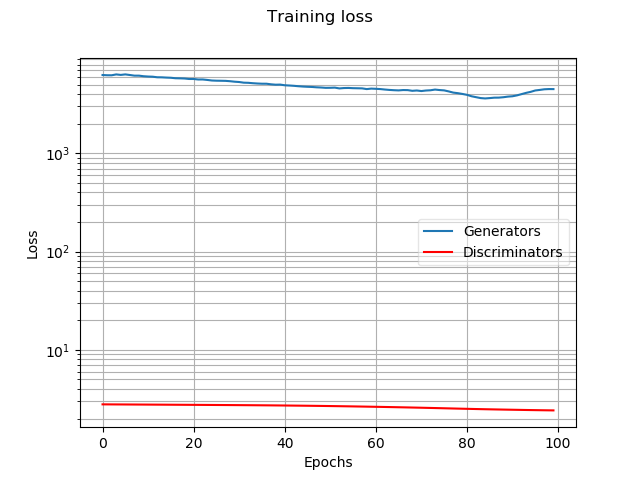

In [23]:
plt.suptitle("Training loss")
plt.semilogy(losses_g, label="Generators")
plt.semilogy(losses_d, label="Discriminators", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, which ='both')
plt.legend(loc='best', fancybox=True, framealpha=0.5)
plt.show()
# plt.savefig("CrystalGAN_training_losses_D.pdf")

<IPython.core.display.Javascript object>


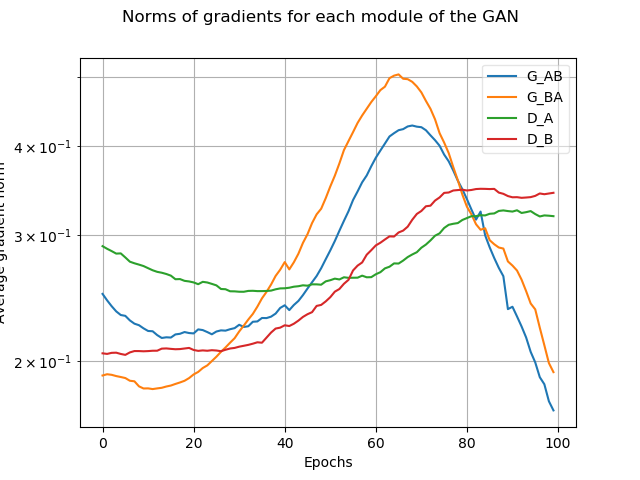

In [24]:
plt.suptitle("Norms of gradients for each module of the GAN")
plt.semilogy(grad_norms['G_AB'], label="G_AB")
plt.semilogy(grad_norms['G_BA'], label="G_BA")
plt.semilogy(grad_norms['D_A'], label="D_A")
plt.semilogy(grad_norms['D_B'], label="D_B")
plt.xlabel("Epochs")
plt.ylabel("Average gradient norm")
plt.grid(True, which ='both')
plt.legend(loc='best', fancybox=True, framealpha=0.5)
plt.show()

In [25]:
# Generate new pseudobinary components (POSCAR files)
datasets = [X_dataset, Y_dataset]
pseudobinary_components = {metals[0]: [], metals[1]: []}
generators = [G_AB, G_BA]
target_folders = [generated_data + pseudobinary_X_data, generated_data + pseudobinary_Y_data]
for i in range(len(datasets)):
    idx = 0 # POSCAR file index
    for j in range(len(datasets[i])):
        idx += 1
        new_component = generators[i](torch.from_numpy(datasets[i][j]))
        pseudobinary_components[metals[i]].append(new_component)
        save_as_poscar(new_component, target_folders[i] + "POSCAR_" + str(idx), metal=metals[i])

In [26]:
# Feature transfer step where we generate ternary components
# from pseudobinary ones
ternary_components = {metals[0]: [], metals[1]: []}
for i in range(len(pseudobinary_components[metals[0]])):
    for j in range(len(pseudobinary_components[metals[1]])):
        component1 = pseudobinary_components[metals[0]][i]
        component2 = pseudobinary_components[metals[1]][j]
        
        # X component receives Y part of Y component
        ternary_components[metals[0]].append(torch.cat((component1[:3 + nH, :], component1[3 + nH:3 + nH + nX, :], \
                                   component2[3 + nH + nX:3 + nH + nX + nY, :])))
        # Y component receives X part of X component
        ternary_components[metals[1]].append(torch.cat((component2[:3 + nH, :], component1[3 + nH:3 + nH + nX, :], \
                                   component2[3 + nH + nX:3 + nH + nX + nY, :])))

In [27]:
# Convert ternary data to POSCAR files
target_folders = [generated_data + ternary_X_data, generated_data + ternary_Y_data]
for i in range(len(ternary_components.keys())):
    idx = 0
    for x in ternary_components[list(ternary_components.keys())[i]]:
        idx += 1
        save_as_poscar(x, target_folders[i] + "POSCAR_" + str(idx))

In [29]:
# Save ternary data as .npy files
# ternary_data_arrays = [np.array([data.detach().numpy() for data in ternary_components[metals[0]]]),
#                        np.array([data.detach().numpy() for data in ternary_components[metals[1]]])]
# np.save(generated_data + npy_data + metals[0] + "-" + metals[1] + ".npy", ternary_data_arrays[0])
# np.save(generated_data + npy_data + metals[1] + "-" + metals[0] + ".npy", ternary_data_arrays[1])

<IPython.core.display.Javascript object>


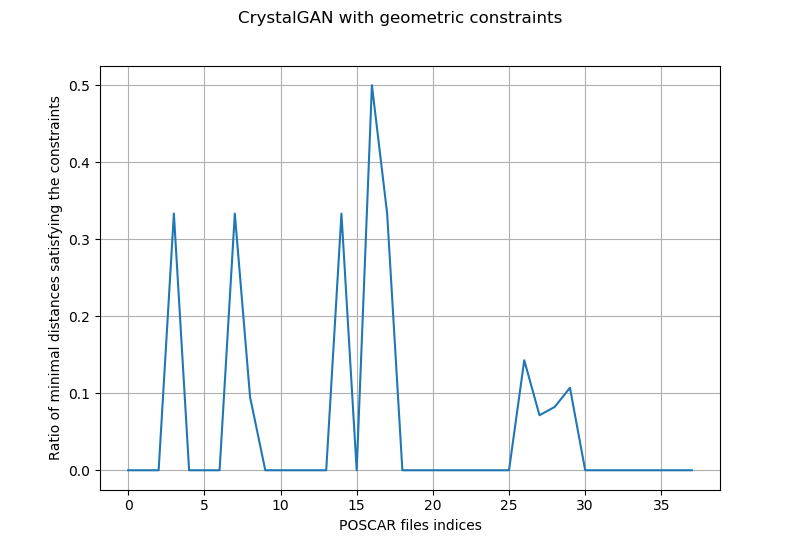

In [48]:
fig = plt.figure(figsize=(8, 5.5))
plt.grid(True, which ='both')
plt.suptitle("CrystalGAN with geometric constraints")
plt.xlabel("POSCAR files indices")
plt.ylabel("Ratio of minimal distances satisfying the constraints")
# Plot ratio of satisfied interatomic distances for pseudobinary_X_data
nb_poscars_X = len(X_dataset)
success_ratios = []
for i in range(nb_poscars_X):
    d = np.array(minimal_distances(generated_data + pseudobinary_X_data + "POSCAR_" + str(i + 1), metal=metals[0], is_poscar=True))
    res = len(np.where((d >= lb) & (d <= ub))[0]) / len(d)
    success_ratios.append(res)
plt.plot(success_ratios)

<IPython.core.display.Javascript object>


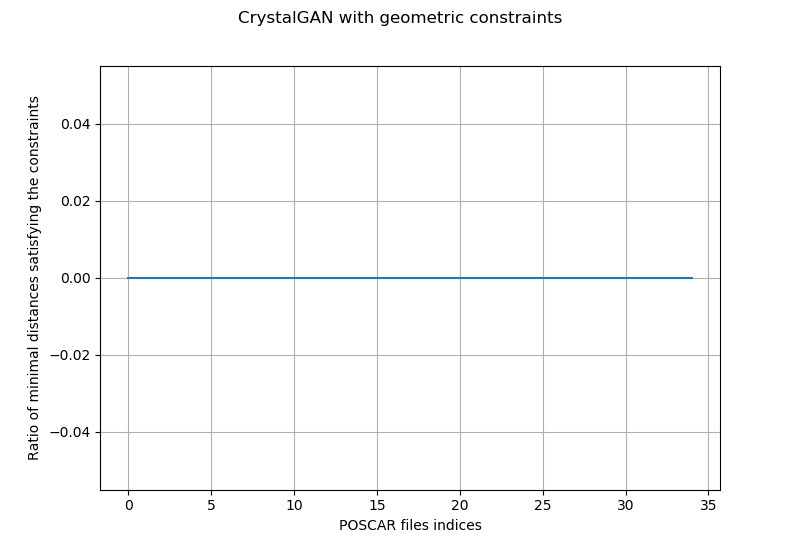

In [49]:
fig = plt.figure(figsize=(8, 5.5))
plt.grid(True, which ='both')
plt.suptitle("CrystalGAN with geometric constraints")
plt.xlabel("POSCAR files indices")
plt.ylabel("Ratio of minimal distances satisfying the constraints")
# Plot ratio of satisfied interatomic distances for pseudobinary_Y_data
nb_poscars_Y = len(Y_dataset)
success_ratios = []
for i in range(nb_poscars_Y):
    d = np.array(minimal_distances(generated_data + pseudobinary_Y_data + "POSCAR_" + str(i + 1), metal=metals[0], is_poscar=True))
    res = len(np.where((d >= lb) & (d <= ub))[0]) / len(d)
    success_ratios.append(res)
plt.plot(success_ratios)

<IPython.core.display.Javascript object>


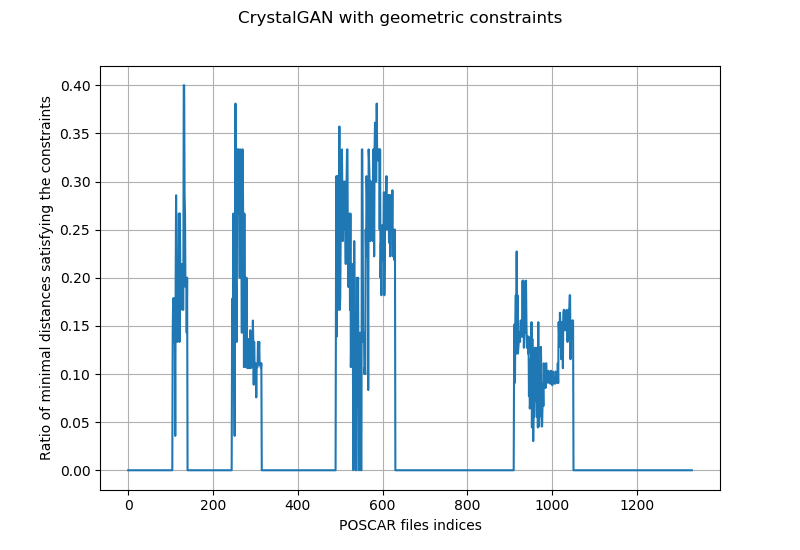

In [53]:
fig = plt.figure(figsize=(8, 5.5))
plt.grid(True, which ='both')
plt.suptitle("CrystalGAN with geometric constraints")
plt.xlabel("POSCAR files indices")
plt.ylabel("Ratio of minimal distances satisfying the constraints")
# Indices of POSCARs we want to plot the ratio of satisfied interatomic distances for
# Default: All
l = 0
u = nb_poscars_X * nb_poscars_Y
success_ratios = []
# Plot ratio of satisfied interatomic distances for generated ternary data
# Ternary data are stored in two variables: ternary_X_data and ternary_Y_data
# Modify data_to_plot to plot either data set
data_to_plot = ternary_Y_data # Or: ternary_Y_data
for i in range(l, u):
    d = np.array(minimal_distances(generated_data + data_to_plot + "POSCAR_" + str(i + 1), metal=None, is_poscar=True))
    res = len(np.where((d >= lb) & (d <= ub))[0]) / len(d)
    success_ratios.append(res)
plt.plot(success_ratios)
# To save figure, uncomment line below and change file name if needed
# plt.savefig("success_ratios.pdf")

In [55]:
# Plot indices of "interesting" POSCARs. To recover the file name
# add 1 to the displayed ratios
ratio_of_interest = 0.8
np.where(np.array(success_ratios) >= ratio_of_interest)[0]

array([], dtype=int64)

In [56]:
# To get the right files, print data_to_plot
data_to_plot

'Ternary_data/Ni-Pd_poscars/'